In [1]:
%config Completer.use_jedi = False

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVR, SVR
from sklearn.decomposition import PCA

import xgboost as xgb

from joblib import dump, load

## Helper Functions

The functions below are functions I use throughout the notebook to eliminate using the same code repeatedly.

In [3]:
### Remove a feature if it has correlation with another at least at the threshold
def remove_highly_correlated_features(X, threshold=0.9):
    corrs = X.corr()
    N = corrs.shape[0]
    corrs_to_keep = [True]*N

    for i in range(N):
        if corrs_to_keep[i] == False:
            continue
        for j in range(i+1, N):
            if corrs_to_keep[j] == False:
                continue
            else:
                curr_corr = corrs.iloc[i, j]
                if curr_corr >= threshold:
                    corrs_to_keep[j] = False

    feats_to_keep = X.columns[corrs_to_keep]
    return feats_to_keep


### BMI feature
def get_bmi(df):
    df['BMI'] = df['Weight']/df['Height']**2 * 10000 # conversion for our units
    return df


### Fit the model using GridSearchCV on X_train, y_train. Get back the model with best params and scores.
def model_params_and_scores(model, X_train, y_train):
    """
    Input a model pipeline, and return the best model,
    along with its best parameters and 5 best test scores.
    """
    model.fit(X_train, y_train)
    best_params = model.best_params_
    best_scores = pd.DataFrame(model.cv_results_)['mean_test_score'].sort_values(ascending=False)[:5]
    
    return model, best_params, best_scores


### Visualize the residuals from the test set (If random, then good!)
def visualize_residuals(y_test, residuals, model_alias):
    plt.scatter(y_test, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residual Plot for the {model_alias} Model')
    plt.xlabel('True BodyFat')
    plt.ylabel('Residual')
    plt.show()
    

### Residuals distribution (Should look ~ normal centered around zero)
def visualize_residual_dist(residuals, model_alias):
    sns.histplot(x=residuals, kde=True)
    plt.title(f"Residual Distribution for {model_alias} Model")
    

### Visualize the coefficients of a model if it has such an attribute. 
### Provide a model alias to make the visual prettier.
def visualize_coefficients(model, X_train, model_alias=None):
    """
    If the model has coefficients (linear model), then visualize the coefficients
    """
    coefs = model.coef_
    coefs_ser = pd.Series(index=X_train.columns, data=coefs)
    coefs_ser_nonzero = coefs_ser[coefs_ser!=0]
    plt.figure(figsize=(0.75*len(coefs_ser_nonzero), 6))
    sns.barplot(x=coefs_ser_nonzero.index, y=coefs_ser_nonzero.values)
    plt.xticks(rotation=90)
    plt.title(f'Coefficients for the {model_alias} model')
    
    
### Test set evaluation
def test_set_eval(model, X_test, y_test):
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    mape = mean_absolute_percentage_error(y_test, preds)
    
    print(f"The MSE, RMSE, MAE, and MAPE for {model.best_estimator_[-1]} are \n\n"
           f"{mse}, {rmse}, {mae}, and {mape}.")

In [4]:
df = pd.read_csv('bodyfat.csv')

In [5]:
df.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


The dataset was obtained from here:

https://www.kaggle.com/fedesoriano/body-fat-prediction-dataset

Density can be used to directly calculate BodyFat percentage based on an equation, so it will not be used.
BodyFat is given as a percentage, which is the target.

The dimensions for the data is as follows:

Age (years)
Weight (lbs)
Height (inches)
All remaining measurements are in cm.

In [6]:
# For ease of the user wanting to use a model to predict BodyFat, all the measurements should be the same (imperial or metric)

# I will convert Weight to kg and Height to cm

df['Weight'] = df['Weight'] / 2.20462
df['Height'] = df['Height'] * 2.54

df.drop('Density', axis=1, inplace=True)
X = df.drop('BodyFat', axis=1)
y = df['BodyFat']

Check for any nulls, duplicates, or strange values in df

In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

BodyFat    0
Age        0
Weight     0
Height     0
Neck       0
Chest      0
Abdomen    0
Hip        0
Thigh      0
Knee       0
Ankle      0
Biceps     0
Forearm    0
Wrist      0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BodyFat  252 non-null    float64
 1   Age      252 non-null    int64  
 2   Weight   252 non-null    float64
 3   Height   252 non-null    float64
 4   Neck     252 non-null    float64
 5   Chest    252 non-null    float64
 6   Abdomen  252 non-null    float64
 7   Hip      252 non-null    float64
 8   Thigh    252 non-null    float64
 9   Knee     252 non-null    float64
 10  Ankle    252 non-null    float64
 11  Biceps   252 non-null    float64
 12  Forearm  252 non-null    float64
 13  Wrist    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


With no nulls, duplicates, and all data types being numeric, that means the data is cleaned. I will now perform a train-test split then look into the data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
# for ease of visualizations, combine X and y parts to make train set
train = pd.concat([X_train, y_train], axis=1)

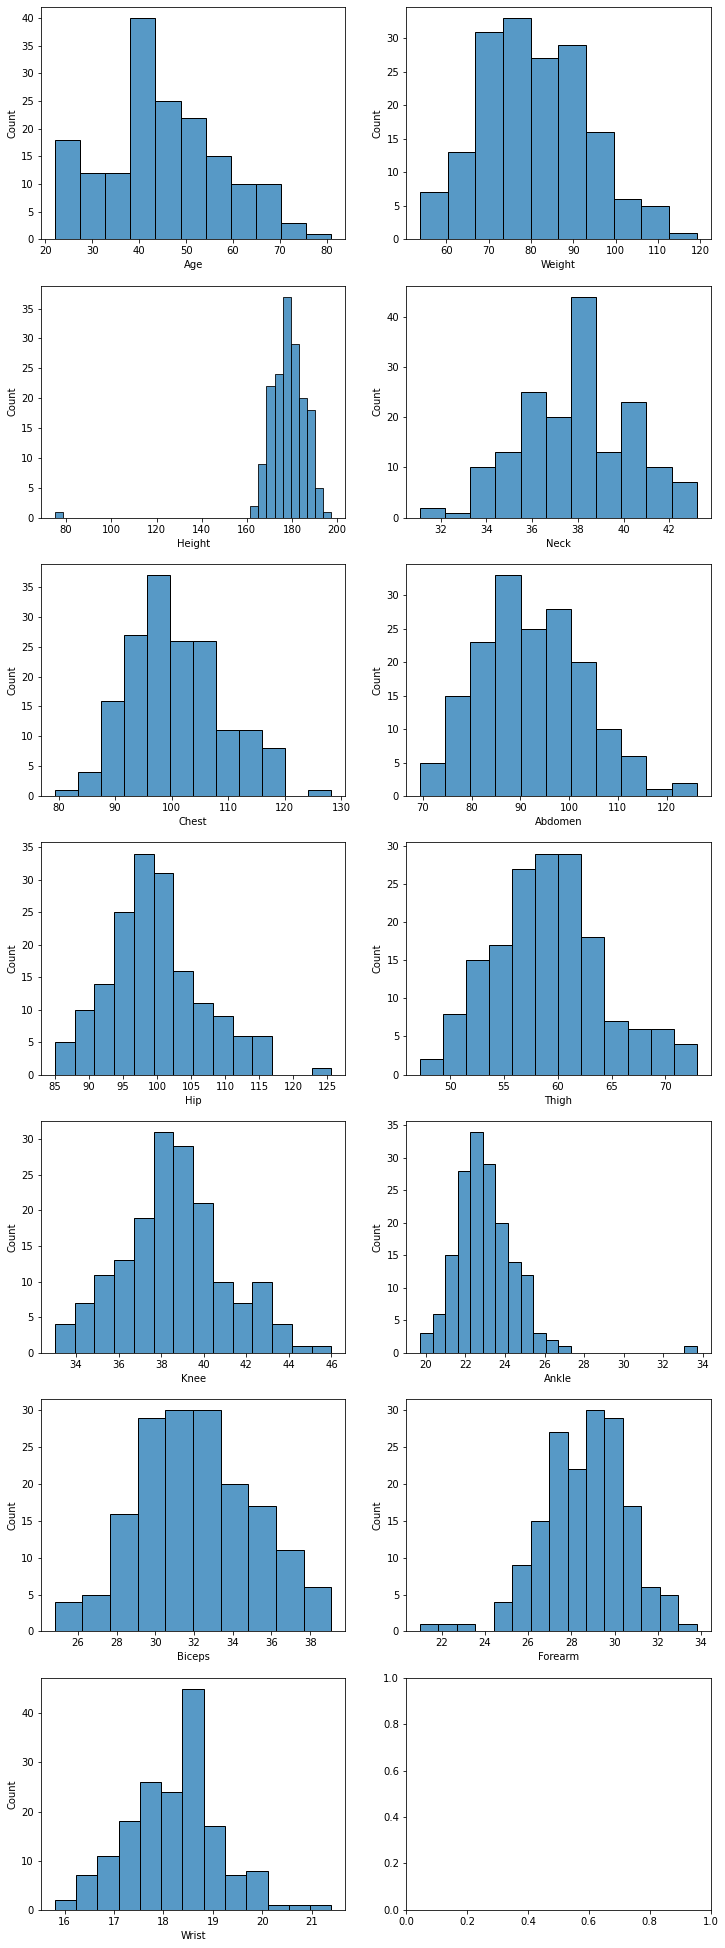

In [12]:
cols_for_viz = X_train.columns

N = len(cols_for_viz)

N_COLS = 2

if N % N_COLS == 0:
    N_ROWS = N // N_COLS
else:
    N_ROWS = N // N_COLS + 1
    
i = 0 # counter

fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(6*N_COLS, 5*N_ROWS))

for col in cols_for_viz:
    row_num = i // N_COLS
    col_num = i % N_COLS
    sns.histplot(data=X_train, x=col, ax=ax[row_num][col_num])
    i += 1

Above, nothing is too alarming except one of the heights taken is about half of the next lowest one. 

There is also an ankle measurement which appears as an outlier.

I will look into these.

In [13]:
train.sort_values(by='Height', ascending=True).iloc[0]

Age         44.000000
Weight      92.986546
Height      74.930000
Neck        36.600000
Chest      106.000000
Abdomen    104.300000
Hip        115.500000
Thigh       70.600000
Knee        42.500000
Ankle       23.700000
Biceps      33.600000
Forearm     28.700000
Wrist       17.400000
BodyFat     32.900000
Name: 41, dtype: float64

In [14]:
train.sort_values(by='Ankle', ascending=False).iloc[0]

Age         67.000000
Weight      75.750016
Height     171.450000
Neck        36.500000
Chest       98.900000
Abdomen     89.700000
Hip         96.200000
Thigh       54.700000
Knee        37.800000
Ankle       33.700000
Biceps      32.400000
Forearm     27.700000
Wrist       18.200000
BodyFat     26.600000
Name: 85, dtype: float64

The above shows that they are not the same data value, so it makes sense to look at both.

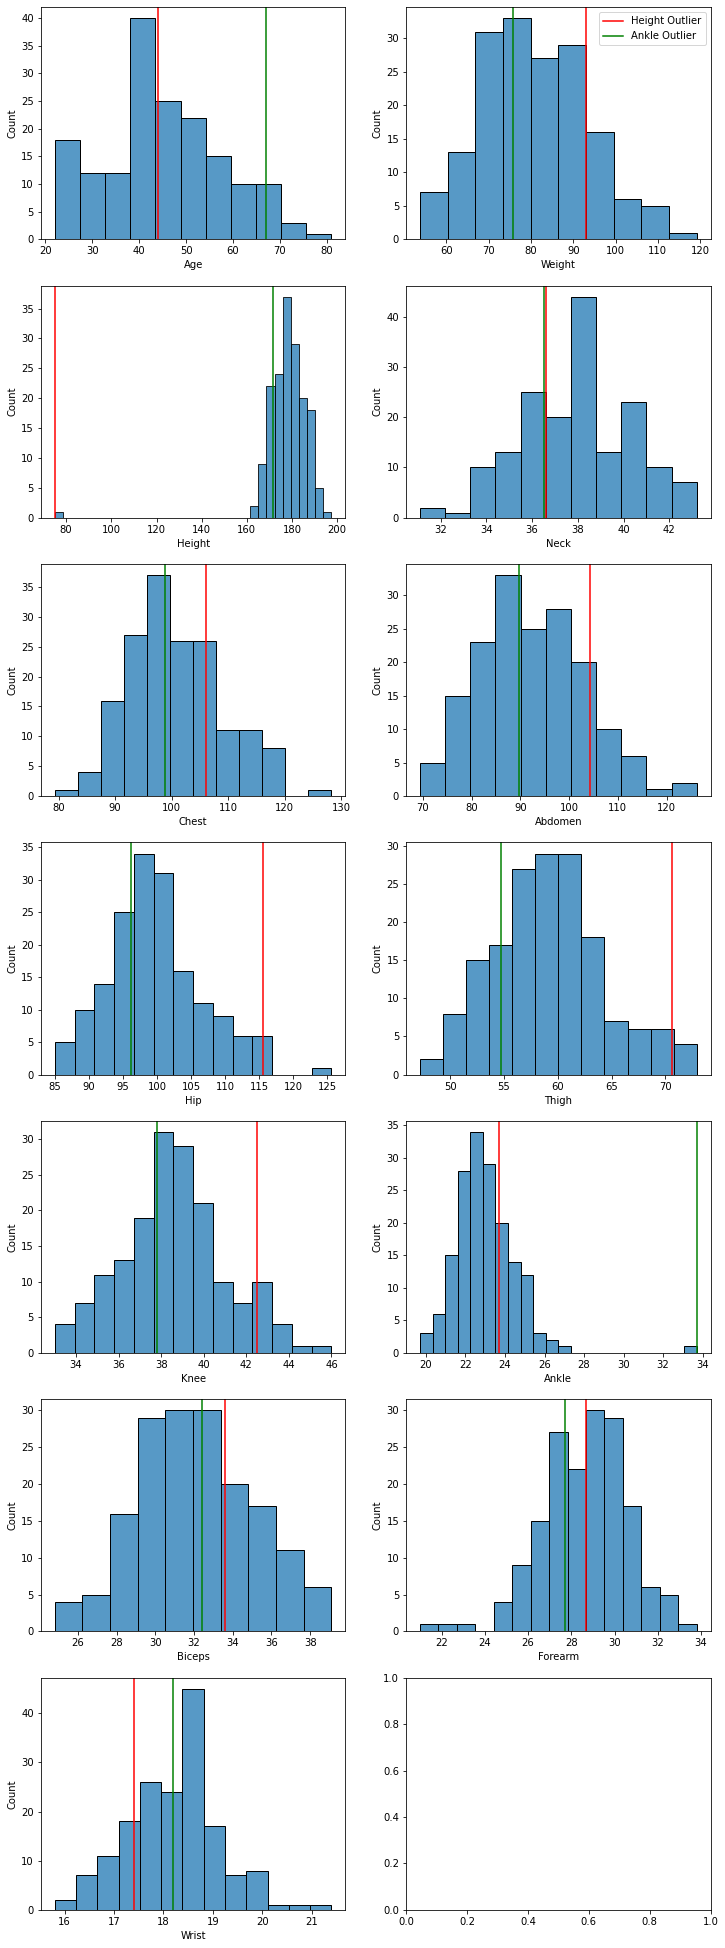

In [15]:
cols_for_viz = X_train.columns

outlier_height = train.sort_values(by='Height', ascending=True).iloc[0]
outlier_ankle = train.sort_values(by='Ankle', ascending=False).iloc[0]

N = len(cols_for_viz)

N_COLS = 2

if N % N_COLS == 0:
    N_ROWS = N // N_COLS
else:
    N_ROWS = N // N_COLS + 1
    
i = 0 # counter

fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(6*N_COLS, 5*N_ROWS))

for col in cols_for_viz:
    row_num = i // N_COLS
    col_num = i % N_COLS
    sns.histplot(data=X_train, x=col, ax=ax[row_num][col_num])
    ax[row_num][col_num].axvline(x=outlier_height[i], color='red', label='Height Outlier')
    ax[row_num][col_num].axvline(x=outlier_ankle[i], color='green', label='Ankle Outlier')
    if i == 1:
        ax[row_num][col_num].legend()
    i += 1

As we can see above, both of the data values have, except for their outlying feature, rather normal data values otherwise.

Given the possibility that  an individual may have swollen ankles, I will leave the ankle_outlier untouched. However, I find it unlikely that the height_outlier is not, at least, an error; this individual was half the height of the second shortest individual in this study, yet had a normal weight measurement. For that reason, I will remove this data point.

In [16]:
train[train['Height']<100]

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BodyFat
41,44,92.986546,74.93,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4,32.9


In [17]:
# remove the outlier above based on index
idx = train.sort_values(by='Height', ascending=True).iloc[0].name

train.drop([idx], inplace=True)
X_train.drop([idx], inplace=True)
y_train.drop([idx], inplace=True)

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Now that we have looked at the outliers, I want to add in a feature: BMI, which is the proportional to the height / weight**2.

In [18]:
train = get_bmi(train)
X_train = get_bmi(X_train)
X_test = get_bmi(X_test)

<ipython-input-3-2ab775aedea7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BMI'] = df['Weight']/df['Height']**2 * 10000 # conversion for our units


<AxesSubplot:>

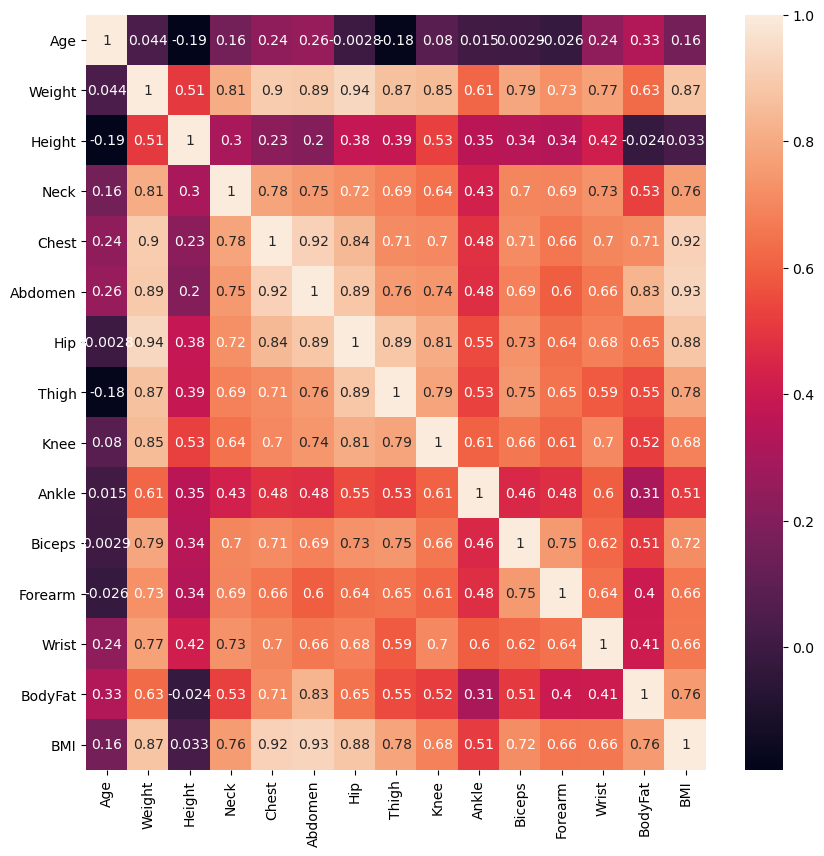

In [19]:
plt.figure(figsize=(10, 10), dpi=100)
sns.heatmap(data=train.corr(), annot=True)

As we can see, many features are strongly correlated with each other. I will remove any features that have correlation of at least 0.9 with another feature.

In [20]:
feats_to_keep = remove_highly_correlated_features(X_train, threshold=0.9)

X_train_low_corr = X_train[feats_to_keep]
X_test_low_corr = X_test[feats_to_keep]

I will now look at the 'BodyFat' (target) category more closely

<AxesSubplot:xlabel='BodyFat', ylabel='Count'>

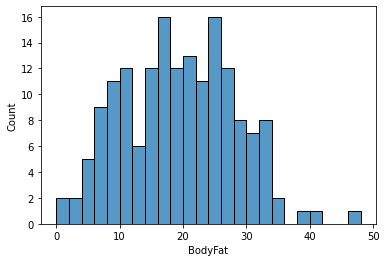

In [30]:
sns.histplot(x=y_train, binwidth=2)

In [31]:
y_train.describe()

count    167.000000
mean      19.301796
std        8.782290
min        0.000000
25%       12.250000
50%       19.500000
75%       25.650000
max       47.500000
Name: BodyFat, dtype: float64

Concerning to me is that the binwidth is set at two. As we can see above, there is a BodyFat = 0, which is impossible, but it is also very unlikely for anyone to have BodyFat < 3%, and typically, < 5% is not really able to be maintained for more than a short amount of time.

I will remove the data with BodyFat = 0

In [34]:
train = train[train['BodyFat']>0]
X_train = train.drop('BodyFat', axis=1)
y_train = train['BodyFat']

X_train_low_corr = X_train[feats_to_keep]

I now want to look at the predictors vs target more closely.

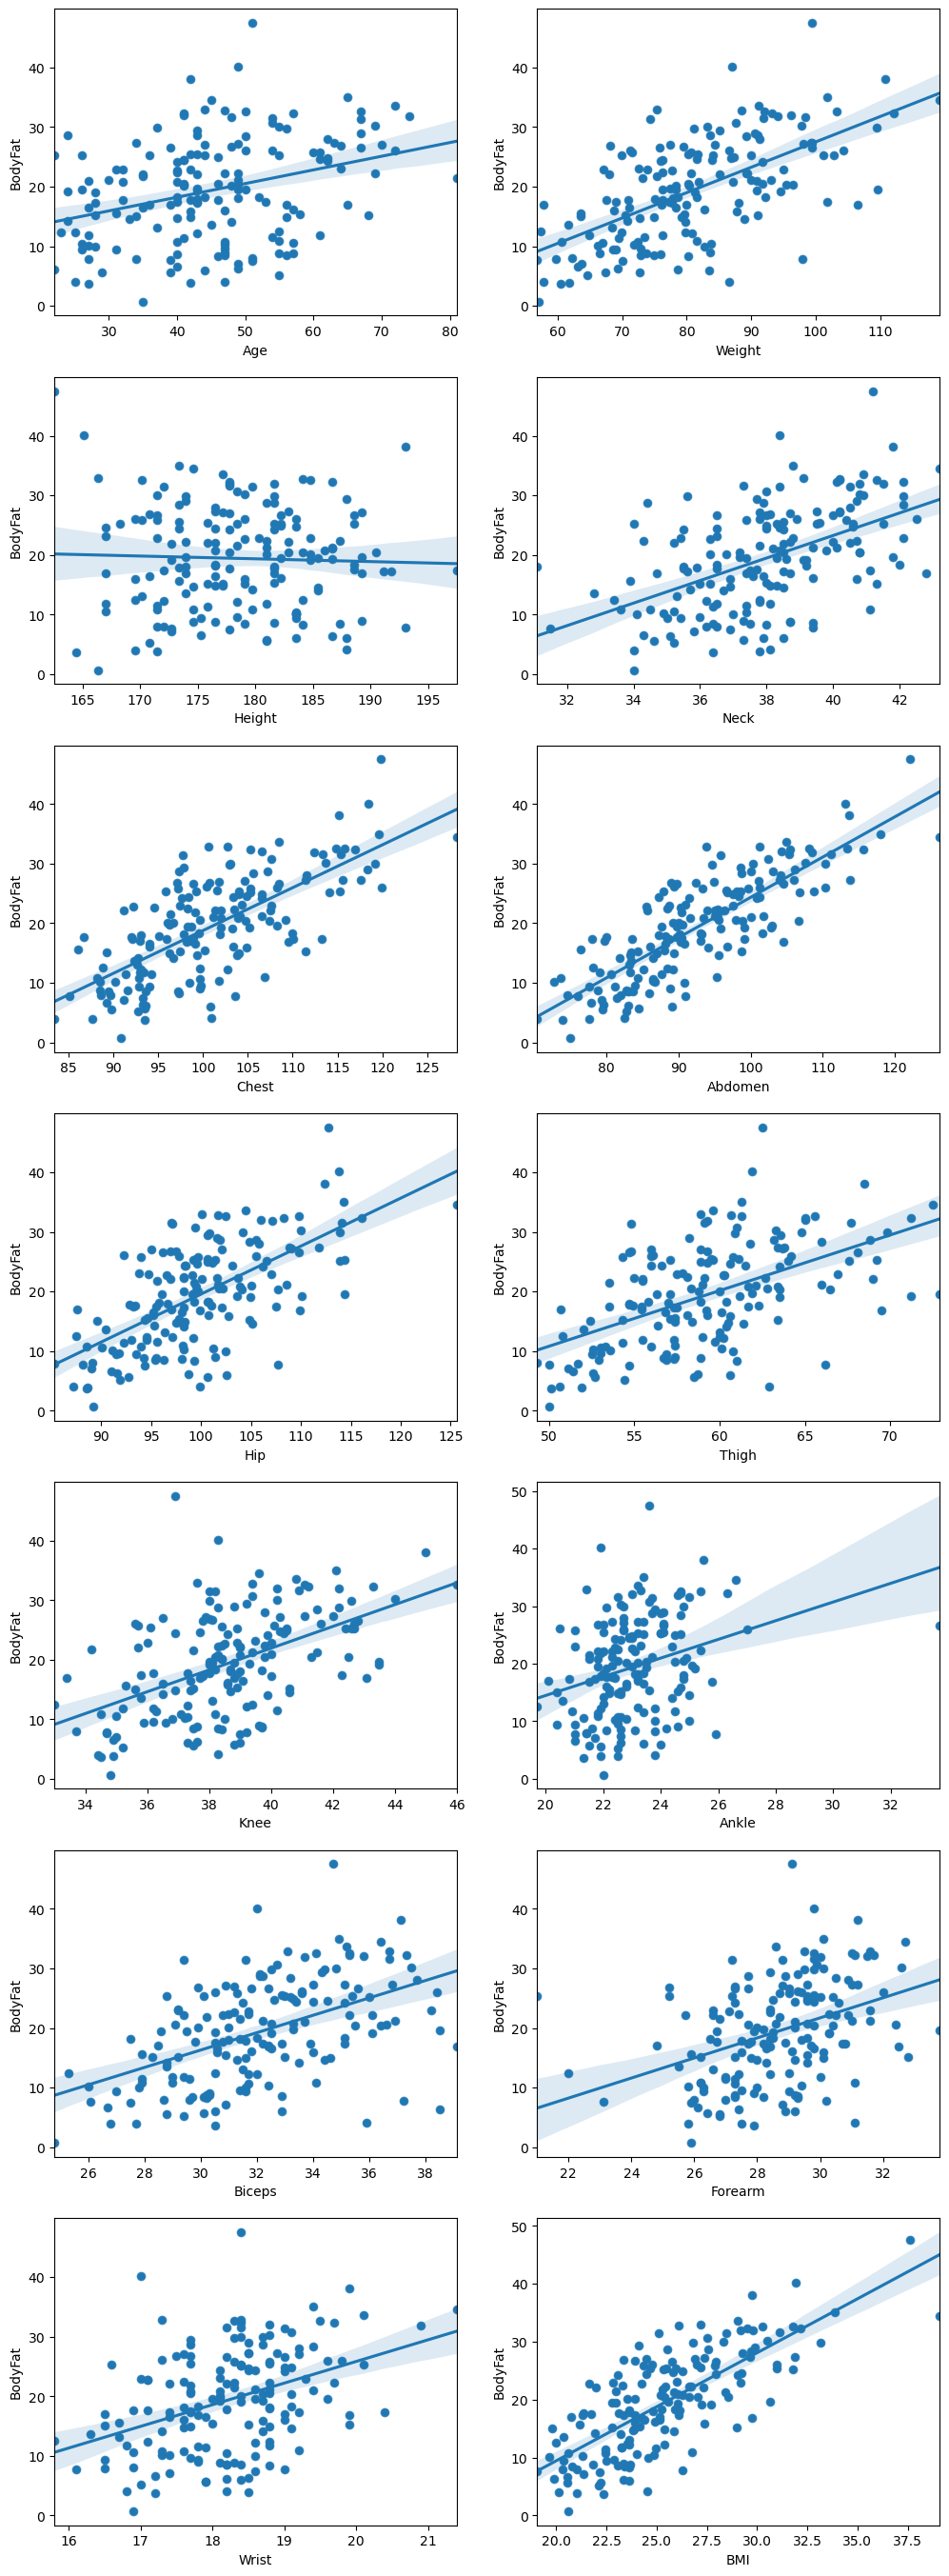

In [35]:
features = X_train.columns

N = len(features)

NCOLS = 2

if N % NCOLS == 0:
    NROWS = N // NCOLS
else:
    NROWS = N // NCOLS + 1
    
i = 0 # counter
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(6*NCOLS, 5*NROWS), dpi=100)

for feat in features:
    row_num = i // NCOLS
    col_num = i % NCOLS
    sns.scatterplot(data=train, x=feat, y='BodyFat', ax=ax[row_num][col_num])
    sns.regplot(x=feat,y='BodyFat',data=train, ax=ax[row_num][col_num])
    ax[row_num][col_num].set_xlabel(feat)
    ax[row_num][col_num].set_ylabel('BodyFat')
    i += 1
    

The above pictures confirm our findings on the correlation matrix. Specifically, we can see the abdomen appears to have the tightest fit, whereas the height and age seem to have no clear correlation. This does make sense as these measurements would not (directly) influence a person's Bodyfat percentage.

Of further interest is that the ankle outlier we looked at before is not as far off on the trend-line. So while it is an outlier in just looking at the ankle data solely, it does not appear as though it will have a significant detrimental impact.

While this is not a huge dataset, I will do some PCA analysis to see if it is worth trying to implement PCA.

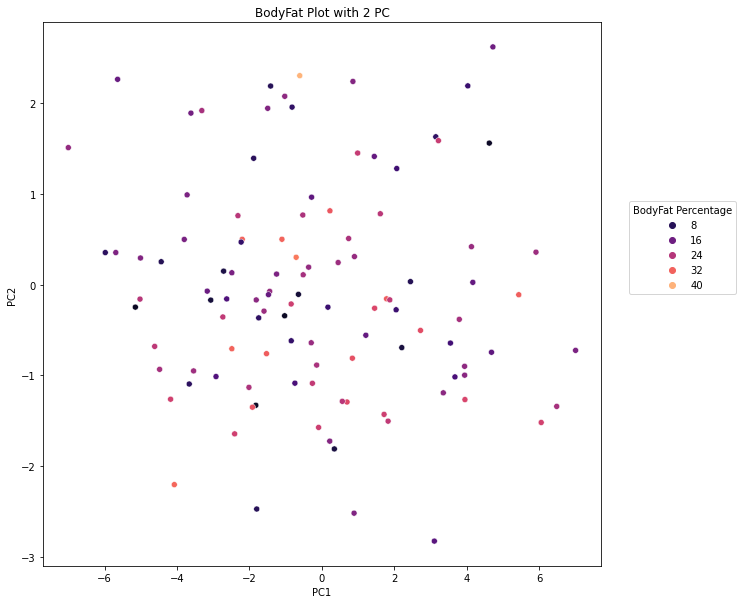

In [39]:
# visualize two component PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca_2 = PCA(n_components=2)
X_train_pca = pca_2.fit_transform(X_train_scaled)

X_train_pca = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2'])
train_pca = pd.concat([X_train_pca, y_train], axis=1)

plt.figure(figsize=(10, 10))
sns.scatterplot(data=train_pca, x='PC1', y='PC2', hue='BodyFat', palette='magma')
plt.title('BodyFat Plot with 2 PC')
plt.legend(loc=(1.05, 0.5), title='BodyFat Percentage')
plt.show()

In [40]:
np.sum(pca_2.explained_variance_ratio_)

0.7487272986965855

As we can see, even though 2 principal components accounts for 75% of the variance, there is still no clear distribution to make clear predictions. I will perform PCA to have the threshold of 95% of the explained variance of the data kept.

In [41]:
pca = PCA(n_components=0.95, svd_solver='full')

X_pca = pca.fit_transform(X_train_scaled)

pca.n_components_

8

The number of components to use to have at least 95% of the explained variance is 8. Since X_train had 14 features at the start, this cuts the amount of features almost in half.

In [42]:
scaler = StandardScaler()
X_train_low_scaled = scaler.fit_transform(X_train_low_corr)

pca = PCA(n_components=0.95, svd_solver='full')

X_low_pca = pca.fit_transform(X_train_low_scaled)

pca.n_components_

7

I observe here that using the low correlation training set, 7 features were required to contain at least 95%. While this is less than 8 (using the full), it is a reduction from 11 to 7 features. Because this is a small dataset, I will create a model on this as well.

## Model creation

### Model on full training dataset

I want to begin by creating a model on the full training dataset.

In [52]:
net = ElasticNet(max_iter=100000)
scaler = StandardScaler()

net_pipeline = Pipeline([
    ('scaler', scaler),
    ('net', net),
])

net_params = {
    'net__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'net__l1_ratio': [0, 0.1, 0.5, 0.9, 1],
}

net_grid_full = GridSearchCV(estimator=net_pipeline, param_grid=net_params, cv=5, scoring='neg_mean_squared_error')

In [53]:
net_full_model, net_full_best_params, net_full_best_scores = model_params_and_scores(net_grid_full, X_train, y_train)

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1128.7438644828696, tolerance: 0.928144265151515
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1097.278403994446, tolerance: 1.0791998796992481
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1179.6250920287434, tolerance: 0.9603544210526316
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3731.0104581380947, tolerance: 0.9712431578947368
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3982.0106622584976, tolerance: 1.0274028270676692
  model = cd_fast.enet_coordinate_descent(


In [54]:
print(f"The best params for Full ElasticNet are \n {net_full_best_params} \n\n"
      f"with best MSE of \n {net_full_best_scores}.")

The best params for Full ElasticNet are 
 {'net__alpha': 0.1, 'net__l1_ratio': 0.9} 

with best MSE of 
 18   -23.106775
19   -23.176887
5    -23.667491
6    -23.668955
7    -23.681967
Name: mean_test_score, dtype: float64.


Since the best scores are all roughly the same, further hyperparamater searching not yield much progress. I will now run a model on the variables will low correlation.


### Model Creation without Highly Correlated Features

In [55]:
# create model and pipeline

net = SGDRegressor(max_iter=100000)
scaler = StandardScaler()

net_pipeline = Pipeline([
    ('scaler', scaler),
    ('net', net),
])

net_params = {
    'net__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'net__l1_ratio': [0, 0.1, 0.5, 0.9, 1],
}

net_grid_low = GridSearchCV(estimator=net_pipeline, param_grid=net_params, cv=5, scoring='neg_mean_squared_error')

In [56]:
net_low_model, net_low_best_params, net_low_best_scores = model_params_and_scores(net_grid_low, X_train_low_corr, y_train)

In [57]:
print(f"The best params for ElasticNet Low Corr Model are \n {net_low_best_params} \n\n"
      f"with best MSE of \n {net_low_best_scores}.")

The best params for ElasticNet Low Corr Model are 
 {'net__alpha': 0.01, 'net__l1_ratio': 0.5} 

with best MSE of 
 12   -24.317758
3    -24.343962
6    -24.348231
13   -24.350653
9    -24.365912
Name: mean_test_score, dtype: float64.


As we can see, the cross validation best scores are slightly better with the low correlation data. However, we should keep in mind this is MSE and not RMSE, so the relative difference is a bit lower.


### Model Creation with PCA on Full Training

In [61]:
# create model and pipeline

net = ElasticNet()
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver='full')

net_pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('net', net),
])

net_params = {
    'net__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'net__l1_ratio': [0, 0.1, 0.5, 0.9, 1],
}

net_grid_pca = GridSearchCV(estimator=net_pipeline, param_grid=net_params, cv=5, scoring='neg_mean_squared_error')

In [62]:
net_pca_model, net_pca_best_params, net_pca_best_scores = model_params_and_scores(net_grid_pca, X_train, y_train)

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1667.651952163324, tolerance: 0.928144265151515
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1500.9188593831332, tolerance: 1.0791998796992481
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1523.0535906009304, tolerance: 0.9603544210526316
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2153.4336934086823, tolerance: 1.242854578313253
  model = cd_fast.enet_coordinate_descent(


In [63]:
print(f"The best params for ElasticNet Full PCA are \n {net_pca_best_params} \n\n"
      f"with best MSE of \n {net_pca_best_scores}.")

The best params for ElasticNet Full PCA are 
 {'net__alpha': 0.1, 'net__l1_ratio': 0} 

with best MSE of 
 15   -29.540159
16   -29.592286
17   -29.827980
18   -30.136966
19   -30.226605
Name: mean_test_score, dtype: float64.


As we can see, using PCA to retain only ~95% explained variance, the model performed much worse on the full training set. 

### Model on Low Correlation with PCA

In [64]:
# create model and pipeline

net = ElasticNet()
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver='full')

net_pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('net', net),
])

net_params = {
    'net__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'net__l1_ratio': [0, 0.1, 0.5, 0.9, 1],
}

net_grid_pca_low = GridSearchCV(estimator=net_pipeline, param_grid=net_params, cv=5, scoring='neg_mean_squared_error')

In [65]:
net_pca_low_model, net_pca_low_best_params, net_pca_low_best_scores = model_params_and_scores(net_grid_pca_low, X_train_low_corr, y_train)

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1646.7225377666812, tolerance: 0.928144265151515
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1464.2597774537644, tolerance: 1.0791998796992481
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1496.1071881444002, tolerance: 0.9603544210526316
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linea

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2257.861613110618, tolerance: 1.242854578313253
  model = cd_fast.enet_coordinate_descent(


In [66]:
print(f"The best params for ElasticNet Low Corr PCA are \n {net_pca_low_best_params} \n\n"
      f"with best MSE of \n {net_pca_low_best_scores}.")

The best params for ElasticNet Low Corr PCA are 
 {'net__alpha': 0.1, 'net__l1_ratio': 0} 

with best MSE of 
 15   -29.401185
16   -29.422531
17   -29.552125
18   -29.761288
19   -29.829608
Name: mean_test_score, dtype: float64.


Similar to the case when PCA was not used, there is a very minor increase best scores; however, it is clear for this dataset that having only 95% of the explained variance is not good enough.

### ElasticNet Best Model

For the four models above, the best models are the two done without PCA. We can see on their cross-validation sets that the MSE is very close for each. I will now evaluate each model on the test set.

In [67]:
test_set_eval(net_full_model, X_test, y_test)

The MSE, RMSE, MAE, and MAPE for ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=100000) are 

20.137960043355996, 4.487533848714235, 3.4982106166488838, and 0.24390171342066497.


In [68]:
test_set_eval(net_low_model, X_test_low_corr, y_test)

The MSE, RMSE, MAE, and MAPE for SGDRegressor(alpha=0.01, l1_ratio=0.5, max_iter=100000) are 

21.291978769510052, 4.614323219011652, 3.5221958991316775, and 0.24226395098056608.


As we can see, the model without the highly correlated variables performs better, albeit not in a significant way.

However, it would probably be wise to look at the residuals and see the performance on a deeper level.

Of particular interest to me is that the MAE and MAPE dropped quite a bit more relative to the RMSE for the low correlation model. This can indicate that the model without the high correlated features improves the prediction, but more-so improves for things will smaller error i.e. the data points with lower residuals see the strongest reduction.

To further explore this, we can look at the residual plot of each.

In [69]:
full_preds = net_full_model.predict(X_test)
low_preds = net_low_model.predict(X_test_low_corr)

resid_full = y_test - full_preds
resid_full = resid_full.rename('Residual Full')
resid_low = y_test - low_preds
resid_low = resid_low.rename('Residual Low')

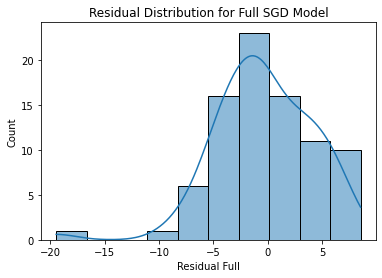

In [70]:
visualize_residual_dist(resid_full, 'Full SGD')

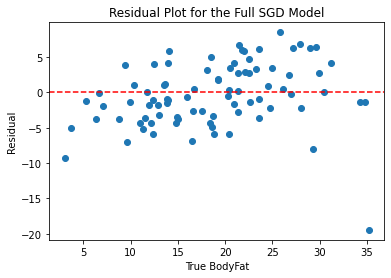

In [71]:
visualize_residuals(y_test, resid_full, 'Full SGD')

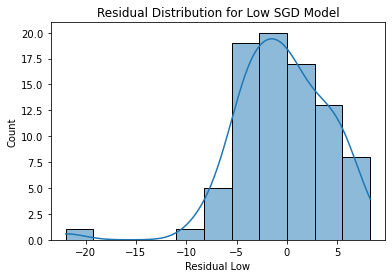

In [72]:
visualize_residual_dist(resid_low, 'Low SGD')

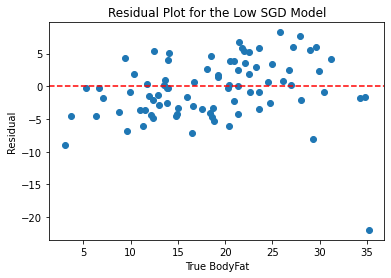

In [73]:
visualize_residuals(y_test, resid_low, 'Low SGD')

The residual distribution above are rather similar, but the residuals for the low correlated dataset tend to look a bit more normal and the scatter plot for the low SGD model is a bit more random.

Of interest to me is the point in the test set that has -20 residual in the Low SGD model. We can see that two other points have similar bodyfat of 35%, but those two have much lesser predicted error.

In [75]:
high_bf = y_test[y_test > 30]
high_bf_idx = high_bf_test.index
high_bf_test_X = X_test_low_corr.loc[high_bf_idx]
high_bf_resids = resid_low.loc[high_bf_idx]

high_bf_test = pd.concat([high_bf_test_X, high_bf, high_bf_resids], axis=1)

high_bf_test

,Age,Weight,Height,Neck,Abdomen,Thigh,Knee,Ankle,Biceps,Forearm,Wrist,BodyFat,Residual Low
242,66,106.254139,182.880,41.4,109.0,63.7,42.4,24.6,35.6,30.7,19.5,30.4,-0.880722
156,28,93.326741,175.260,38.5,105.0,68.6,40.0,25.2,35.2,30.7,19.1,31.2,4.232648
38,46,164.722265,183.515,51.2,148.1,87.3,49.1,29.6,45.0,29.0,21.4,35.2,-21.956746
204,44,101.151219,177.165,40.9,113.9,63.5,40.3,21.8,34.8,30.7,17.4,34.8,-1.571667
168,35,103.532582,176.530,40.4,115.9,74.4,40.6,24.0,36.1,31.8,18.8,34.3,-1.830232


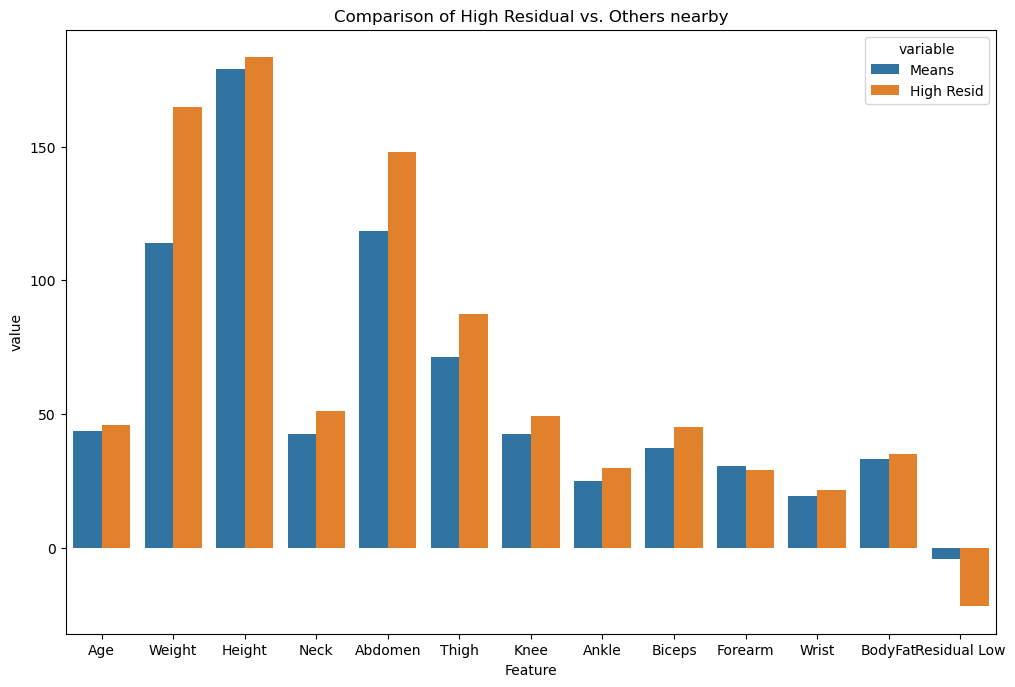

In [77]:
high_bf_test_means = high_bf_test.mean().transpose()
high_bf_test_means = high_bf_test_means.rename('Means')
highest_bf = high_bf_test.loc[38].rename('High Resid')

high_bf_comp = pd.concat([high_bf_test_means, highest_bf], axis=1).reset_index()
high_bf_melted = pd.melt(high_bf_comp, id_vars='index')

plt.figure(figsize=(12, 8), dpi=100)
sns.barplot(data=high_bf_melted, x='index', y='value', hue='variable')
plt.title('Comparison of High Residual vs. Others nearby')
plt.xlabel('Feature');

As we can see from this picture, the weight and abdomen are much larger on the man with the high residual (far overestimation).

With the height being in-line with the others, but much higher weight and abdomen measurement, this could tell us the bodyfat data given for this point is very poor, possibly inaccurate, or this person had a lot of muscle on them. It is important to note here that the measurements only take into account the circumference, so in general, a man with a lot of muscle would have much larger would have larger measurements without having higher bodyfat.

In the future, while gathering this study, a lean body mass weight measure could also be taken, which would help for potential cases like this.

But also, we do want to consider that measurement was not taken well since it was done determined by a formula from the Density.

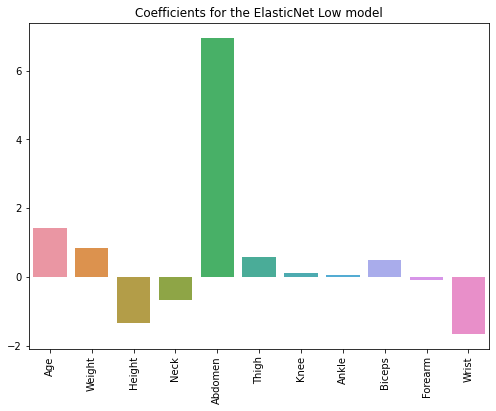

In [79]:
low_net = net_low_model.best_estimator_[-1]

visualize_coefficients(low_net, X_train_low_corr, 'ElasticNet Low')

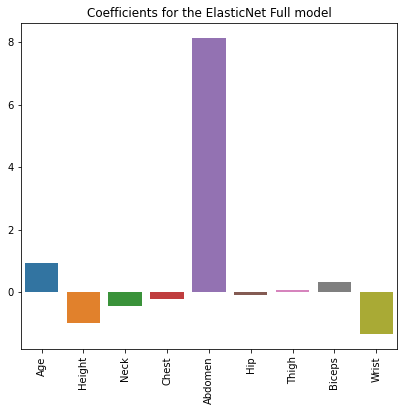

In [82]:
full_net = net_full_model.best_estimator_[-1]

visualize_coefficients(full_net, X_train, 'ElasticNet Full')

A couple interesting things to note:

The model that ran on the full feature set actually ended up with less non-zero features (more shrank to zero). However, we can also see that it is more dependent on Abdomen than the model created on the feature set.

Since the "Full" model did not remove highly correlated features, it is possible the abdomen feature's coefficient is being created higher since there is a negative feature counteracting it. I am going to keep the net_low_model out of these.

In [83]:
dump(net_low_model, 'BodyFatNetModel.joblib') # best model thus far

['BodyFatNetModel.joblib']

### Ratios of Features

Some features that may be interest when performing a test is if we look at ratios of features. Specifically, if we think about the above exampmle where the residual was ~-20, we noted that this person has much larger features overall. However, ratios of features (e.x. Abdomen over Thigh) could give better insight into the data. This is because, while a bodybuilder type of person may have a larger abdomen than an not avid exerciser, the thigh should be bigger as well, helping to alleviate the poor predictions.

I will create new features based on ratios and perform the above to see if any improvements are made. Note that a ratio involving age does not necessarily make sense, so I will not use that one.

In [84]:
class RatioAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Add in ratio for all columns in X except Age
        X_copy = X.copy()
        cols_for_ratios = X_copy.columns.drop('Age')
        N = len(cols_for_ratios)
        
        for i in range(N-1):
            for j in range(i+1, N):
                attr1 = cols_for_ratios[i]
                attr2 = cols_for_ratios[j]
                X_copy[f'{attr1}_over_{attr2}'] = X_copy[attr1] / X_copy[attr2]

        return X_copy

In [85]:
X_train_ratios = RatioAttributesAdder().fit_transform(X_train)
X_test_ratios = RatioAttributesAdder().transform(X_test)

In [86]:
X_train.shape

(166, 14)

In [87]:
X_train_ratios.shape

(166, 92)

In [88]:
feats_to_keep_ratio = remove_highly_correlated_features(X_train_ratios, threshold=0.9)

X_train_ratios = X_train_ratios[feats_to_keep_ratio]
X_test_ratios = X_test_ratios[feats_to_keep_ratio]

In [89]:
X_train_ratios.shape

(166, 77)

In [90]:
# Perform PCA to see visualize first two PC components
scaler = StandardScaler()
X_train_ratios_scaled = scaler.fit_transform(X_train_ratios)

pca_95 = PCA(n_components=0.95, svd_solver='full')
X_pca_95 = pca_95.fit_transform(X_train_ratios_scaled)

pca_95.explained_variance_ratio_[:2]

array([0.34740863, 0.13354458])

As we can see only ~ 47% of the explained variance is accounted for by the first two components.

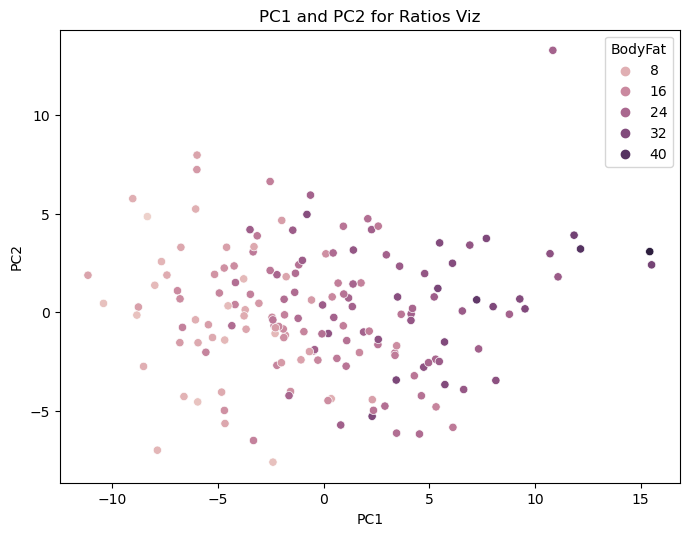

In [91]:
# plot the first two
plt.figure(figsize=(8,6),dpi=100)
sns.scatterplot(x=X_pca_95[:,0], y=X_pca_95[:,1], hue=y_train)
plt.title('PC1 and PC2 for Ratios Viz')
plt.xlabel('PC1')
plt.ylabel('PC2');

In comparison with the 2 PCs without looking at the ratios, this seems to do a better job, which means the added features may have helped to find more information to help make the model.

I will now create models on the ratios.

## Model Creation with Ratios

I will first look at modeling the data for all of the ratio features (after removing highly correlated ones)

In [92]:
# pipeline with ratios
net = ElasticNet()
scaler = StandardScaler()

net_pipeline = Pipeline([
    ('scaler', scaler),
    ('net', net),
])

net_params = {
    'net__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'net__l1_ratio': [0, 0.1, 0.5, 0.9, 1],
}

net_grid_ratios = GridSearchCV(estimator=net_pipeline, param_grid=net_params, cv=5, scoring='neg_mean_squared_error')

In [93]:
net_ratios_model, net_ratios_params, net_ratios_scores = model_params_and_scores(net_grid_ratios, X_train_ratios, y_train)

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 847.8217318528021, tolerance: 0.928144265151515
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 872.5446471957703, tolerance: 1.0791998796992481
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 900.0137143676405, tolerance: 0.9603544210526316
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_m

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 889.0658179095184, tolerance: 0.9712431578947368
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 937.7360652051404, tolerance: 1.0274028270676692
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 935.5221722738197, tolerance: 0.928144265151515
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_m

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1003.2009347248597, tolerance: 0.9603544210526316
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 870.8199118022268, tolerance: 0.9712431578947368
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 920.214723231813, tolerance: 1.0274028270676692
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2519.6403251867177, tolerance: 1.0791998796992481
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2469.937828384674, tolerance: 0.9603544210526316
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2358.5072137795155, tolerance: 0.9712431578947368
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linea

In [94]:
print(f"The best params for Elastic Net with Ratios are \n {net_ratios_params} \n\n"
      f"with best MSE of \n {net_ratios_scores}.")

The best params for Elastic Net with Ratios are 
 {'net__alpha': 1, 'net__l1_ratio': 0.5} 

with best MSE of 
 22   -22.686868
12   -22.907354
10   -23.019962
11   -23.031054
21   -23.038954
Name: mean_test_score, dtype: float64.


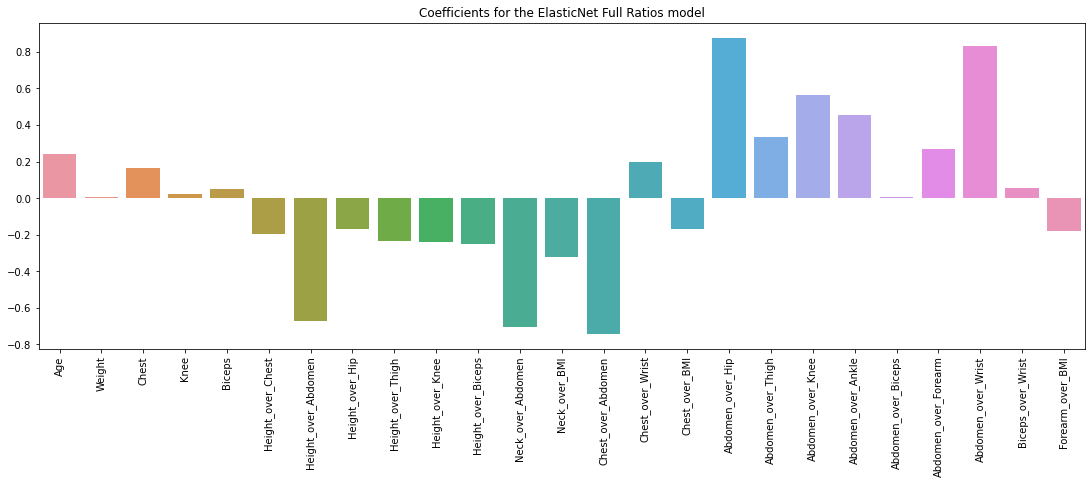

In [96]:
visualize_coefficients(net_ratios_model.best_estimator_[-1], X_train_ratios, model_alias='ElasticNet Full Ratios')

As we can see, there is slight improvement in the mean_test_score vs. not using the ratios. However, the amount of nonzero features is rather high, so I do not think it is best to proceed with this.

### Model with Ratios and PCA

In [97]:
# pipeline with ratios
net = ElasticNet()
scaler = StandardScaler()
pca = PCA(n_components=0.95, svd_solver='full')

net_pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca),
    ('net', net),
])

net_params = {
    'net__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'net__l1_ratio': [0, 0.1, 0.5, 0.9, 1],
}

net_grid_ratios_pca = GridSearchCV(estimator=net_pipeline, param_grid=net_params, cv=5, scoring='neg_mean_squared_error')

net_ratios_pca_model, net_ratios_pca_params, net_ratios_pca_scores = model_params_and_scores(net_grid_ratios_pca, X_train_ratios, y_train)

print(f"The best params for {net_ratios_pca_model.best_estimator_[-1]} are \n {net_ratios_pca_params} \n\n"
      f"with best MSE of \n {net_ratios_pca_scores}.")

C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1346.0863717697355, tolerance: 0.928144265151515
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1148.7958174963476, tolerance: 1.0791998796992481
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1293.7840387851156, tolerance: 0.9603544210526316
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linea

The best params for ElasticNet(alpha=0.1, l1_ratio=1) are 
 {'net__alpha': 0.1, 'net__l1_ratio': 1} 

with best MSE of 
 19   -23.040073
18   -23.046867
17   -23.075968
14   -23.080186
13   -23.081066
Name: mean_test_score, dtype: float64.


C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2527.432596180509, tolerance: 1.0791998796992481
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2477.751529594184, tolerance: 0.9603544210526316
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2368.1025978502857, tolerance: 0.9712431578947368
  model = cd_fast.enet_coordinate_descent(
C:\Users\Ethan\anaconda3\envs\py3TF2\lib\site-packages\sklearn\linear

In [99]:
net_ratios_pca_model.best_estimator_[1].n_components_

10

As seen above, perform PCA does not maintain the results as well as non-pca. However, it does have half the necessary features (10) as the better performing model (20). Still, this does not perform better than the model from the previous part without ratios, so I will not look at this one.

In [100]:
test_set_eval(net_ratios_model, X_test_ratios, y_test)

The MSE, RMSE, MAE, and MAPE for ElasticNet(alpha=1) are 

16.514377344678035, 4.063788545763428, 3.34779327332764, and 0.2497330433444711.


We can see pretty solid improvements on the test set for the RMSE, although the improvements on the MAE are not as drastic, and the MAPE is virtually identical.

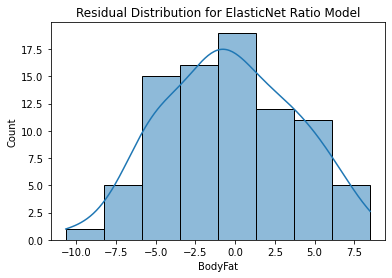

In [102]:
ratio_preds = net_ratios_model.predict(X_test_ratios)
residuals_ratio = y_test - ratio_preds

visualize_residual_dist(residuals_ratio, 'ElasticNet Ratio')

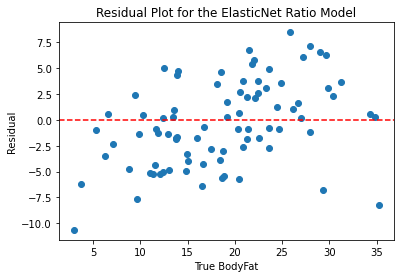

In [103]:
visualize_residuals(y_test, residuals_ratio, 'ElasticNet Ratio')

As we can see from the residual ratio plot there is not as large of residuals at the extremities, especially with that curious testing point we noticed before.

Without considering the increased need for attributes for the ratio model, this would seem to be the preferred model as the extremities do not have as poor of prediction. However, needing to go through and have 20 features (and an intermediate step of creating 92) requires much more data to be processed.

Additionally, the more extreme a BodyFat percentage is recorded, the more likely it is to be wrong as, ultimately, it is observed by a human (there is not a formula).

I will keep the above model as the best.

### SVM Model


Based on the visual above of the first two primary components (with ratios), it appears as though SVM may perform well. Additionally, it would be smart to use PCA for SVM since it is, typically, rather slow to run.

In [104]:
lin_svr = LinearSVR(max_iter=10000, random_state=42)
pca_95 = PCA(n_components=0.95, svd_solver='full')
scaler = StandardScaler()

lin_svr_pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca_95),
    ('lin_svr', lin_svr),
])

lin_svr_params = {
    'lin_svr__epsilon': [0, 0.001, 0.01, 0.1],
    'lin_svr__C': [0.001, 0.01, 0.1, 1],
    'lin_svr__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
}

lin_svr_pca_grid = GridSearchCV(estimator=lin_svr_pipeline, param_grid=lin_svr_params, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)


lin_svr_pca_model, lin_svr_pca_params, lin_svr_pca_scores = model_params_and_scores(lin_svr_pca_grid, X_train_ratios, y_train)

print(f"The best params for {lin_svr_pca_model.best_estimator_[-1]} are \n {lin_svr_pca_params} \n\n"
      f"with best MSE of \n {lin_svr_pca_scores}.")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=squared_epsilon_insensitive; total time=   0.

[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.01, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.01, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.01, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.01, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__eps

### Without PCA

In [105]:
lin_svr = LinearSVR(max_iter=10000, random_state=42)
scaler = StandardScaler()

lin_svr_pipeline = Pipeline([
    ('scaler', scaler),
    ('lin_svr', lin_svr),
])

lin_svr_params = {
    'lin_svr__epsilon': [0, 0.001, 0.01, 0.1],
    'lin_svr__C': [0.001, 0.01, 0.1, 1],
    'lin_svr__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
}

lin_svr_grid = GridSearchCV(estimator=lin_svr_pipeline, param_grid=lin_svr_params, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)


lin_svr_model, lin_svr_params, lin_svr_scores = model_params_and_scores(lin_svr_grid, X_train_ratios, y_train)

print(f"The best params for {lin_svr_model.best_estimator_[-1]} are \n {lin_svr_params} \n\n"
      f"with best MSE of \n {lin_svr_scores}.")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.001, lin_svr__epsilon=0, lin_svr__loss=squared_epsilon_insensitive; total time=   0.

[CV] END lin_svr__C=0.1, lin_svr__epsilon=0, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, lin_svr__loss=squared_epsilon_insensitive; total time=   0.0s
[CV] END lin_svr__C=0.1, lin_svr__epsilon=0.001, 

### Non-linear Kernel

In [106]:
svr = SVR()
pca_95 = PCA(n_components=0.95, svd_solver='full')
scaler = StandardScaler()

svr_pipeline = Pipeline([
    ('scaler', scaler),
    ('pca', pca_95),
    ('svr', svr),
])

svr_params = {
    'svr__kernel': ['rbf', 'poly'],
    'svr__degree': [2, 3],
    'svr__epsilon': [0, 0.001, 0.01, 0.1],
    'svr__C': [0.001, 0.01, 0.1, 1],
}

svr_pca_grid = GridSearchCV(estimator=svr_pipeline, param_grid=svr_params, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)

svr_pca_model, svr_pca_params, svr_pca_scores = model_params_and_scores(svr_pca_grid, X_train_ratios, y_train)

print(f"The best params for {svr_pca_model.best_estimator_[-1]} are \n {svr_pca_params} \n\n"
      f"with best MSE of \n {svr_pca_scores}.")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END svr__C=0.001, svr__degree=2, svr__epsilon=0, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.001, svr__degree=2, svr__epsilon=0, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.001, svr__degree=2, svr__epsilon=0, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.001, svr__degree=2, svr__epsilon=0, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.001, svr__degree=2, svr__epsilon=0, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.001, svr__degree=2, svr__epsilon=0, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.001, svr__degree=2, svr__epsilon=0, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.001, svr__degree=2, svr__epsilon=0, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.001, svr__degree=2, svr__epsilon=0, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.001, svr__degree=2, svr__epsilon=0, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.001, svr__degre

[CV] END svr__C=0.01, svr__degree=2, svr__epsilon=0.01, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.01, svr__degree=2, svr__epsilon=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__degree=2, svr__epsilon=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__degree=2, svr__epsilon=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__degree=2, svr__epsilon=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__degree=2, svr__epsilon=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.01, svr__degree=2, svr__epsilon=0.1, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.01, svr__degree=2, svr__epsilon=0.1, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.01, svr__degree=2, svr__epsilon=0.1, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.01, svr__degree=2, svr__epsilon=0.1, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.01, svr__degree=2, svr__epsilon=0.1, svr__kernel=poly; total time=

[CV] END svr__C=0.1, svr__degree=3, svr__epsilon=0.001, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__degree=3, svr__epsilon=0.001, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__degree=3, svr__epsilon=0.001, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__degree=3, svr__epsilon=0.001, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__degree=3, svr__epsilon=0.001, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.1, svr__degree=3, svr__epsilon=0.001, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.1, svr__degree=3, svr__epsilon=0.001, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.1, svr__degree=3, svr__epsilon=0.001, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.1, svr__degree=3, svr__epsilon=0.001, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=0.1, svr__degree=3, svr__epsilon=0.01, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=0.1, svr__degree=3, svr__epsilon=0.01, svr__kernel=rbf; tota

[CV] END svr__C=1, svr__degree=3, svr__epsilon=0.01, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=1, svr__degree=3, svr__epsilon=0.01, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=1, svr__degree=3, svr__epsilon=0.01, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=1, svr__degree=3, svr__epsilon=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=1, svr__degree=3, svr__epsilon=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=1, svr__degree=3, svr__epsilon=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=1, svr__degree=3, svr__epsilon=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=1, svr__degree=3, svr__epsilon=0.1, svr__kernel=rbf; total time=   0.0s
[CV] END svr__C=1, svr__degree=3, svr__epsilon=0.1, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=1, svr__degree=3, svr__epsilon=0.1, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=1, svr__degree=3, svr__epsilon=0.1, svr__kernel=poly; total time=   0.0s
[CV] END svr__C=1, svr_

As seen above, the LinearSVR model with PCA does perform well. Let's plot and analyze.

In [108]:
test_set_eval(lin_svr_pca_model, X_test_ratios, y_test)

The MSE, RMSE, MAE, and MAPE for LinearSVR(C=1, epsilon=0.1, loss='squared_epsilon_insensitive', max_iter=10000,
          random_state=42) are 

18.568019588406532, 4.309062495300634, 3.5402859652695975, and 0.2552964910718504.


Similar to the ElasticNet ratios model, the RMSE is much smaller, but the MAE is essentially the same. We will probably notice a similar pattern happening with the residual plot

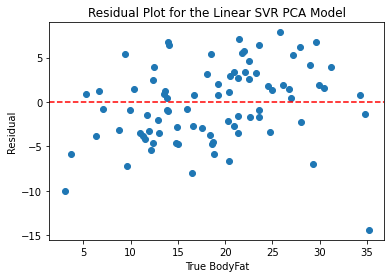

In [109]:
svr_preds = lin_svr_pca_model.predict(X_test_ratios)
svr_resids = y_test - svr_preds

visualize_residuals(y_test, svr_resids, 'Linear SVR PCA')

This does not indicate a better performance, so I will leave the current ElasticNet model as the best.

### Boosted Tree Models

In [110]:
xgbr = xgb.XGBRegressor()


xgbr_params = {
    'n_estimators': [5, 20, 50],
    'max_depth': [2, 4, 6],
    'learning_rate': [0, 0.15, 0.3],
    'booster': ['gbtree'],
}

xgbr_ratios_grid = GridSearchCV(estimator=xgbr, param_grid=xgbr_params, cv=5, scoring='neg_mean_squared_error')

xgbr_ratios_model, xgbr_ratios_params, xgbr_ratios_scores = model_params_and_scores(xgbr_ratios_grid, 
                                                                                    X_train_ratios,
                                                                                    y_train)

print(f"The best params for {xgbr_ratios_model.best_estimator_} are \n {xgbr_ratios_params} \n\n"
      f"with best MSE of \n {xgbr_ratios_scores}.")

The best params for XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) are 
 {'booster': 'gbtree', 'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 50} 

with best MSE of 
 11   -23.402697
10   -24.052222
19   -24.799806
20   -25.621469
22   -26.631578
Name: mean_test_score, dtype: float64.


In [116]:
xgbr_params = {
    'n_estimators': [50, 100],
    'max_depth': [2, 3],
    'learning_rate': [0.15, 0.3],
    'booster': ['gbtree'],
}

xgbr_ratios_grid = GridSearchCV(estimator=xgbr, param_grid=xgbr_params, cv=5, scoring='neg_mean_squared_error')

xgbr_ratios_model, xgbr_ratios_params, xgbr_ratios_scores = model_params_and_scores(xgbr_ratios_grid, 
                                                                                    X_train_ratios,
                                                                                    y_train)

print(f"The best params for XGB Regressor Ratios are \n {xgbr_ratios_params} \n\n"
      f"with best MSE of \n {xgbr_ratios_scores}.")

The best params for XGB Regressor Ratios are 
 {'booster': 'gbtree', 'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 50} 

with best MSE of 
 0   -23.402697
1   -23.418080
2   -25.252215
3   -25.276925
4   -25.621469
Name: mean_test_score, dtype: float64.


In [117]:
xgbr = xgb.XGBRegressor()


xgbr_params = {
    'n_estimators': [5, 20, 50],
    'max_depth': [2, 4, 6],
    'learning_rate': [0, 0.15, 0.3],
    'booster': ['gbtree'],
}

xgbr_grid = GridSearchCV(estimator=xgbr, param_grid=xgbr_params, cv=5, scoring='neg_mean_squared_error')

xgbr_model, xgbr_params, xgbr_scores = model_params_and_scores(xgbr_grid, X_train, y_train)

print(f"The best params for XGB Regressor are \n {xgbr_params} \n\n"
      f"with best MSE of \n {xgbr_scores}.")

The best params for XGB Regressor are 
 {'booster': 'gbtree', 'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 50} 

with best MSE of 
 11   -24.519034
19   -25.321492
20   -25.887423
10   -26.976261
23   -26.992721
Name: mean_test_score, dtype: float64.


As we can see, none of the boosted trees are performing as well as the linear models based on the given scoring metric MSE. As a results, I feel the best model for this comes down to the two discussed prior: The ElasticNet models with and without the ratios.

I will see if their residuals are statistically signficant: The alternative hypothesis being that the residuals_ratio are better.

In [118]:
from scipy.stats import ttest_ind

In [122]:
### residuals_ratio = residuals for the ratio model
### resid_low = residuals for the original model with only low correlation features

stat, p = ttest_ind(residuals_ratio, resid_low)

if p > 0.05:
    print('The two are not statistically significant.')
else:
    print('The residual model performs statistically better at a p-level of 0.05.')

The two are not statistically significant.


As we can see, the residuals are not statistically significant, so the model to choose is the simpler one (non-ratios)

## Saving Final Model Pipeline

In [123]:
model = load('BodyFatNetModel.joblib')

In [124]:
model.best_params_

# create SGD model with these params
# also this model trims the features. Let's recall which ones are used

{'net__alpha': 0.01, 'net__l1_ratio': 0.5}

In [125]:
coefs = model.best_estimator_[-1].coef_

nonzero_coefs_idx = np.nonzero(coefs)

nonzero_coefs = X_train_low_corr.columns[nonzero_coefs_idx]

nonzero_coefs

Index(['Age', 'Weight', 'Height', 'Neck', 'Abdomen', 'Thigh', 'Knee', 'Ankle',
       'Biceps', 'Forearm', 'Wrist'],
      dtype='object')

In [139]:
df = df[df['BodyFat']>5] # remove zero bodyfat data

X = df.drop('BodyFat', axis=1)
y = df['BodyFat']

X_final = X[nonzero_coefs]
y_final = y

In [140]:
final_model = ElasticNet(alpha=0.01, l1_ratio=0.5)
scaler = StandardScaler()

final_pipeline = Pipeline([
    ('scaler', scaler),
    ('net', final_model)
])

final_pipeline.fit(X_final, y_final)

Pipeline(steps=[('scaler', StandardScaler()), ('net', ElasticNet(alpha=0.01))])

In [141]:
preds = final_pipeline.predict(X_final)

rmse = np.sqrt(mean_squared_error(y_final, preds))
mae = mean_absolute_error(y_final, preds)
mape = mean_absolute_percentage_error(y_final, preds)

print(rmse, mae, mape)

4.1469687488683435 3.418352995923095 0.22329773619717377


In [142]:
rel_error = (y_final - preds)/y_final

data=np.column_stack((y_final, preds, rel_error))
columns=['True BodyFat', 'Predicted BodyFat', 'Relative Error']
pd.DataFrame(data=data, columns=columns).sort_values(by='True BodyFat')

,True BodyFat,Predicted BodyFat,Relative Error
215,5.2,16.575172,-2.187533
143,5.3,7.383813,-0.393172
44,5.6,10.208340,-0.822918
28,5.7,12.297977,-1.157540
195,6.0,15.796807,-1.632801
...,...,...,...
233,35.0,37.040172,-0.058291
35,35.2,44.818150,-0.273243
183,38.1,29.264595,0.231900
32,40.1,38.752754,0.033597


In [143]:
final_pipeline[-1].coef_

array([ 0.69538173, -2.64551667, -0.39827147, -0.88234288,  8.90484995,
        0.48976487, -0.1132704 ,  0.24373659,  0.47330117,  0.90472365,
       -1.47848116])

In [150]:
# save the final pipeline along with coefficients to predict
feats_needed = nonzero_coefs.tolist()
with open('FeaturesNeeded.csv', 'w') as f:
    for feat in feats_needed:
        f.write(f'{feat}, ')
    f.close()

In [151]:
dump(final_pipeline, 'FinalBodyFatModel.joblib')

['FinalBodyFatModel.joblib']